**Loading the Dataset**

In [64]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("/content/clean_resume_data.csv")

In [43]:
data.head()

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


In [96]:
data.shape

(2484, 3)

In [48]:
data['Category'].value_counts()

,count
Category,
INFORMATION-TECHNOLOGY,120
BUSINESS-DEVELOPMENT,120
ADVOCATE,118
CHEF,118
ENGINEERING,118
ACCOUNTANT,118
FINANCE,118
FITNESS,117
AVIATION,117


In [49]:
data['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [50]:
from sklearn.utils import resample

# defining the maximum count among all categories
max_count = data['Category'].value_counts().max()

# Resampling each category to match the maximum count
balanced_data = []
for category in data['Category'].unique():
    category_data = data[data['Category'] == category]
    if len(category_data) < max_count:

        # Performing oversampling for categories with fewer samples
        balanced_category_data = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:
        # Performing undersampling for categories with more samples
        balanced_category_data = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balanced_category_data)

# Concatenating the balanced data for all categories
balanced_df = pd.concat(balanced_data)

In [53]:
X = balanced_df['Feature']
y = balanced_df['Category']

# 80% percent data for training and 20% data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# balanced_df.isnull().sum()
balanced_df.dropna(inplace=True)

## **TF-IDF**

In [57]:
X_train = X_train.fillna('')
X_test = X_test.fillna('')
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## **Training Random Forest**

In [58]:
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Accuracy Evaluation
y_pred = rf_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test,y_pred))

Accuracy: 0.8368055555555556
                        precision    recall  f1-score   support

            ACCOUNTANT       0.83      0.95      0.88        20
              ADVOCATE       0.79      0.76      0.77        29
           AGRICULTURE       0.91      0.91      0.91        23
               APPAREL       0.68      0.77      0.72        22
                  ARTS       0.94      0.67      0.78        24
            AUTOMOBILE       1.00      0.68      0.81        19
              AVIATION       0.90      0.96      0.93        28
               BANKING       0.88      0.68      0.77        22
                   BPO       1.00      1.00      1.00        15
  BUSINESS-DEVELOPMENT       0.50      0.50      0.50        18
                  CHEF       0.82      1.00      0.90        28
          CONSTRUCTION       0.93      1.00      0.96        25
            CONSULTANT       0.96      0.77      0.86        31
              DESIGNER       0.90      0.93      0.91        28
         D

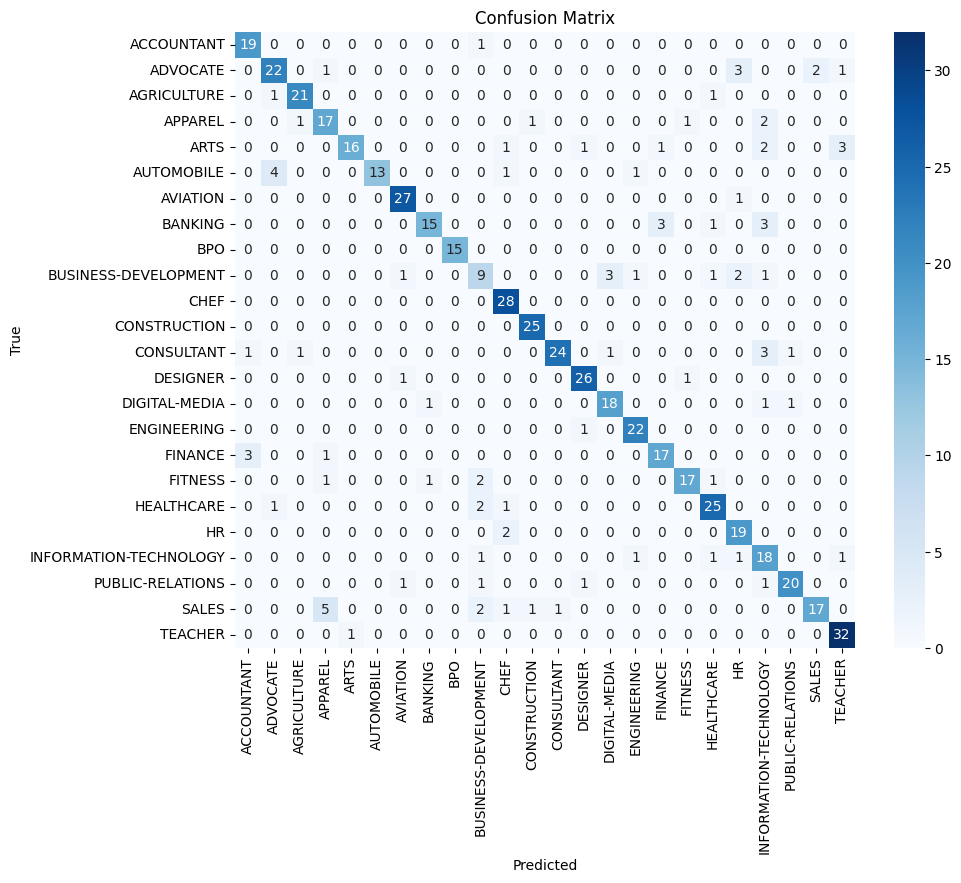

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Assignment 3**

In [66]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import RandomOverSampler

# downloading NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv("clean_resume_data.csv").drop(columns=["ID"]).dropna()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Simplifying categories**

In [97]:
category_map = {
    'INFORMATION-TECHNOLOGY': 'TECH',
    'BUSINESS-DEVELOPMENT': 'BUSINESS',
    'ADVOCATE': 'OTHERS',
    'CHEF': 'OTHERS',
    'ENGINEERING': 'ENGINEERING',
    'ACCOUNTANT': 'BUSINESS',
    'FINANCE': 'BUSINESS',
    'FITNESS': 'OTHERS',
    'AVIATION': 'OTHERS',
    'SALES': 'BUSINESS',
    'BANKING': 'BUSINESS',
    'HEALTHCARE': 'OTHERS',
    'CONSULTANT': 'BUSINESS',
    'CONSTRUCTION': 'ENGINEERING',
    'PUBLIC-RELATIONS': 'BUSINESS',
    'HR': 'HR',
    'DESIGNER': 'TECH',
    'ARTS': 'OTHERS',
    'TEACHER': 'OTHERS',
    'APPAREL': 'OTHERS',
    'DIGITAL-MEDIA': 'TECH',
    'AGRICULTURE': 'OTHERS',
    'AUTOMOBILE': 'ENGINEERING',
    'BPO': 'BUSINESS'
}

df['SimplifiedCategory'] = df['Category'].map(category_map)

## **Extracting Text Features**

In [68]:
def extract_text_features(text_series):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    features = []
    for text in text_series:
        text = str(text).lower()
        tokens = re.findall(r'\b\w+\b', text)
        lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
        num_words = len(tokens)
        num_unique = len(set(tokens))
        avg_word_len = np.mean([len(t) for t in tokens]) if tokens else 0
        num_caps = sum(1 for t in tokens if t.isupper())
        num_digits = sum(c.isdigit() for c in text)
        num_symbols = sum(1 for c in text if not c.isalnum() and not c.isspace())
        features.append([num_words, num_unique, avg_word_len, num_caps, num_digits, num_symbols])
    return pd.DataFrame(features, columns=[
        'num_words', 'num_unique_words', 'avg_word_length',
        'num_capital_words', 'num_digits', 'num_symbols'
    ])

In [93]:
# Add engineered features
feature_df = extract_text_features(df['Feature'])
df = pd.concat([df.reset_index(drop=True), feature_df], axis=1)

# TF-IDF with n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_tfidf = vectorizer.fit_transform(df['Feature'])
X_extra = df[feature_df.columns]
X_all = hstack([X_tfidf, csr_matrix(X_extra.values)])

# Labels
y = df['SimplifiedCategory'].astype(str)

# Oversample
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_all, y)


In [70]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42
)

**Training Random Forest**

In [71]:
clf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

**Evaluation**

In [72]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9315789473684211
              precision    recall  f1-score   support

    BUSINESS       0.86      0.93      0.89       190
 ENGINEERING       0.96      0.97      0.97       190
          HR       0.99      1.00      0.99       190
      OTHERS       0.90      0.78      0.84       190
        TECH       0.94      0.97      0.96       190

    accuracy                           0.93       950
   macro avg       0.93      0.93      0.93       950
weighted avg       0.93      0.93      0.93       950



**Confusion Matrix**

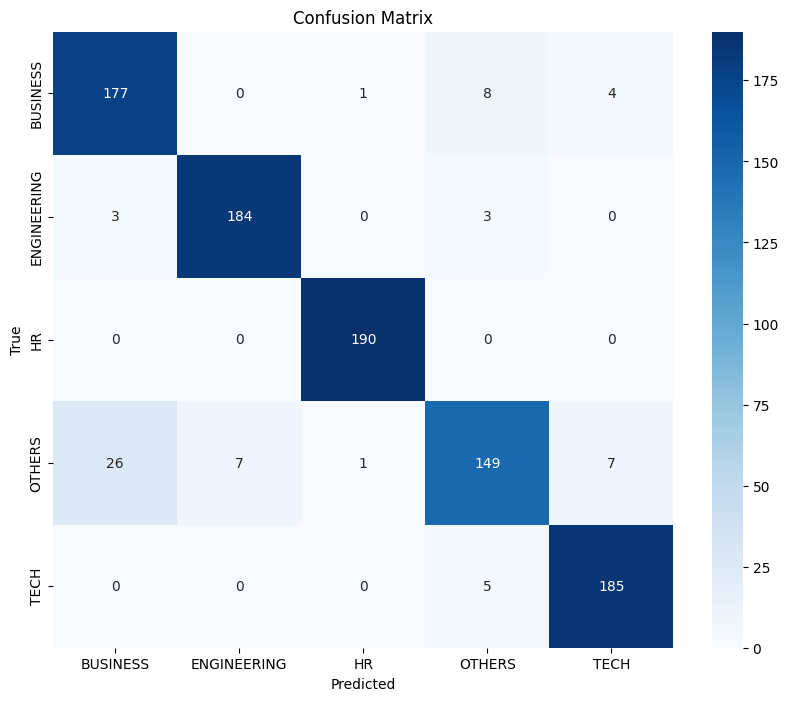

In [94]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Comparison between Random Forest and Random Forest Enhanced**

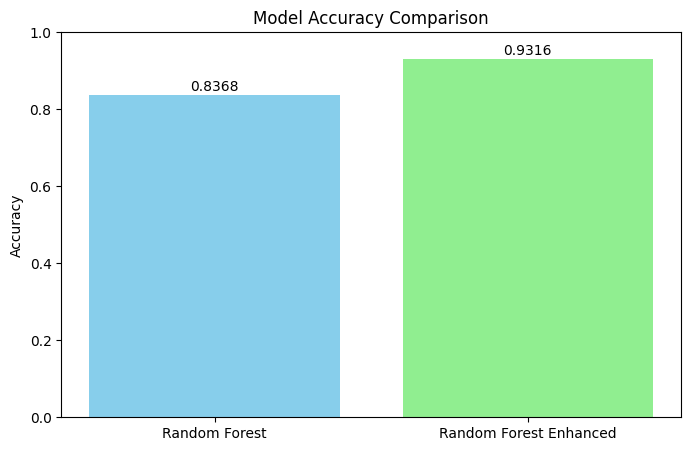

In [95]:
import matplotlib.pyplot as plt

# accuarcies
model_names = ['Random Forest','Random Forest Enhanced']
accuracies=[accuracy,accuracy_score(y_test, y_pred)]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.show()

# **Predictive System**

In [86]:
import re

def cleanResume(txt):
    cleanText = re.sub('http\S+\s', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+', ' ', cleanText)
    cleanText = re.sub('@\S+', ' ', cleanText)
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
    cleanText = re.sub('\s+', ' ', cleanText)
    return cleanText

In [87]:
# Prediction and Category Name
def predict_category(resume_text):
    resume_text = cleanResume(resume_text)
    resume_tfidf = tfidf_vectorizer.transform([resume_text])
    predicted_category = rf_classifier.predict(resume_tfidf)[0]
    return predicted_category

In [88]:
# Example Usage
resume_file = """hr administrator marketing associate hr administrator summary dedicated customer service manager years experience hospitality customer service management respected builder leader customer focused teams strives instill shared enthusiastic commitment customer service highlights focused customer satisfaction team management marketing savvy conflict resolution techniques training development skilled multi tasker client relations specialist accomplishments missouri dot
"""

predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: HR


In [90]:
# Example Usage
resume_file = """Objective:
A creative and detail-oriented Designer with a passion for visual communication and brand identity seeking opportunities to lever

Education:
- Bachelor of Fine Arts in Graphic Design, XYZ College, GPA: 3.7/4.0
- Diploma in Web Design, ABC Institute, GPA: 3.9/4.0

Skills:
- Proficient in Adobe Creative Suite (Photoshop, Illustrator, InDesign)
- Strong understanding of typography, layout, and color theory
- Experience in both print and digital design
- Ability to conceptualize and execute design projects from concept to completion
- Excellent attention to detail and time management skills

Experience:
Graphic Designer | XYZ Design Studio
- Created visually appealing graphics for various marketing materials, including brochures, flyers, and social media posts
- Collaborated with clients to understand their design needs and deliver creative solutions that align with their brand identity
- Worked closely with the marketing team to ensure consistency in brand messaging across all platforms

Freelance Designer
- Designed logos, branding materials, and website layouts for small businesses and startups
- Managed multiple projects simultaneously while meeting tight deadlines and maintaining quality standards
- Established and maintained strong client relationships through clear communication and exceptional service

Projects:
- Rebranding Campaign for XYZ Company: Led a team to redesign the company's logo, website, and marketing collateral, resulting in
- Packaging Design for ABC Product Launch: Developed eye-catching packaging designs for a new product line, contributing to a succ

Certifications:
- Adobe Certified Expert (ACE) in Adobe Illustrator
- Responsive Web Design Certification from Udemy
"""
predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: DESIGNER


# **Deployment**

In [73]:
!pip install streamlit pyngrok --quiet

In [98]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import re
import pickle
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# downloading required NLTK data
nltk.download('stopwords')
nltk.download('wordnet', force=True)
nltk.download('omw-1.4')

# loading the saved model and vectorizer
model = pickle.load(open("rf_model.pkl", "rb"))
vectorizer = pickle.load(open("tfidf_vectorizer.pkl", "rb"))

# feature engineering function
def extract_text_features(text_series):
    stop_words = set(stopwords.words('english'))
    features = []
    for text in text_series:
        text = str(text).lower()
        tokens = re.findall(r'\b\w+\b', text)
        num_words = len(tokens)
        num_unique = len(set(tokens))
        avg_word_len = np.mean([len(t) for t in tokens]) if tokens else 0
        num_caps = sum(1 for t in tokens if t.isupper())
        num_digits = sum(c.isdigit() for c in text)
        num_symbols = sum(1 for c in text if not c.isalnum() and not c.isspace())
        features.append([num_words, num_unique, avg_word_len, num_caps, num_digits, num_symbols])
    return pd.DataFrame(features, columns=[
        'num_words', 'num_unique_words', 'avg_word_length',
        'num_capital_words', 'num_digits', 'num_symbols'
    ])

st.title("Resume Category Classifier")
user_input = st.text_area("Paste Resume Text Below:")

if st.button("Classify"):
    if user_input.strip() == "":
        st.warning("Please enter some resume text.")
    else:
        # processing input
        text_df = pd.Series([user_input])
        extra_features = extract_text_features(text_df)
        tfidf_features = vectorizer.transform(text_df)

        # combining features
        final_input = hstack([tfidf_features, csr_matrix(extra_features.values)])

        # making prediction
        prediction = model.predict(final_input)[0]
        if pd.isna(prediction):
            st.error("Prediction failed. Model returned NaN.")
        else:
            st.success(f"Predicted Category: **{prediction}**")


Overwriting app.py


In [82]:
import pickle

with open("rf_model.pkl", "wb") as f:
    pickle.dump(clf, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [83]:
!ngrok config add-authtoken 2w3AgeUvnrQQ7UWh2xVbIg8litV_7NoZYCVA9sC7qSUyfddaP

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [84]:
from pyngrok import ngrok
import threading
import os

def run_app():
    os.system("streamlit run app.py")

thread = threading.Thread(target=run_app)
thread.start()

public_url = ngrok.connect(8501, "http")
print("Streamlit App is live at:", public_url)

Streamlit App is live at: NgrokTunnel: "https://89c4-34-125-18-81.ngrok-free.app" -> "http://localhost:8501"
